Завдання (крок за кроком)

1. Підготуйте декілька зображень. Це можуть бути RGB або зображення у градаціях сірого, наприклад, у jpg форматі.

2. Виведіть зображення в Colab за допомогою функції imread з бібліотеки matplotlib.

3. Визначить розмір зображення за допомогою функції shape.

4. Оскільки SVD можна застосувати лише до 2D-даних, ми можемо або виконати його для кожного каналу кольору окремо, або ми можемо змінити форму зображення з 3D-матриці на 2D-матрицю, згладивши кожен колірний канал і склавши їх горизонтально (або вертикально).

Для 95% енергії достатньо 10 компонентів.
Для 99% енергії достатньо 29 компонентів.
Для 100% енергії достатньо 56 компонентів.


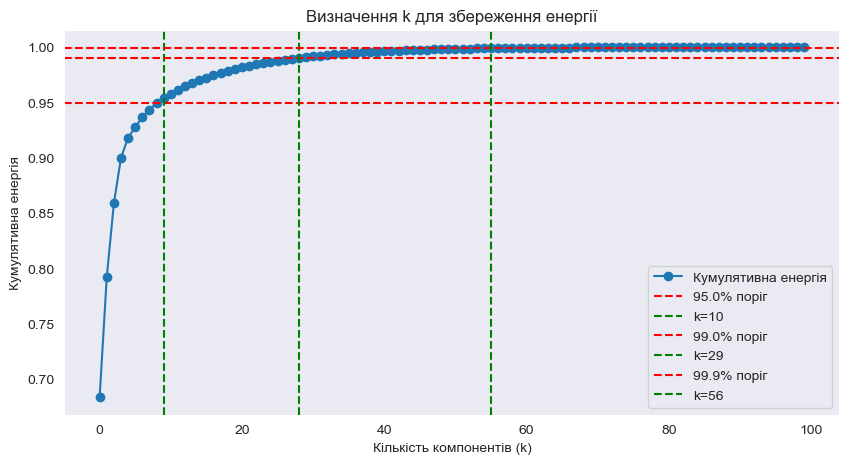

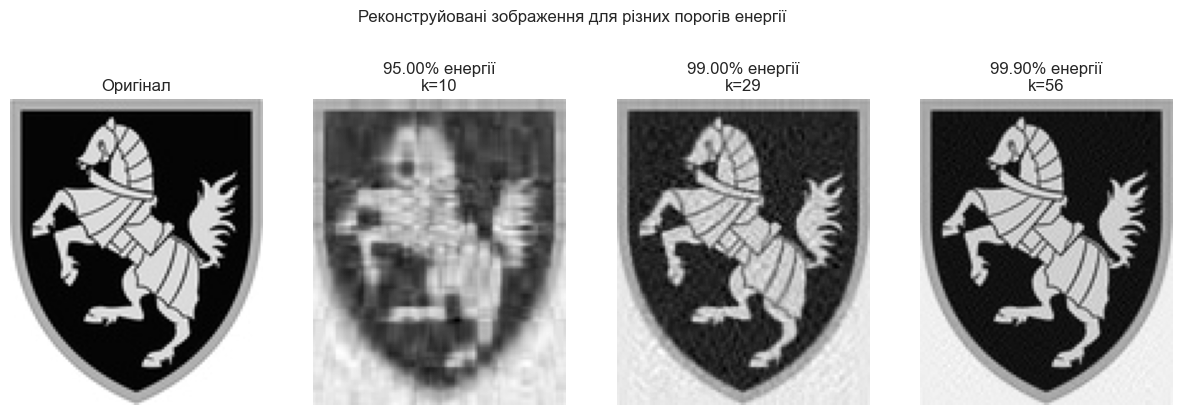

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

# Функція для обчислення кумулятивної енергії та вибору k
def find_k_for_energy(Sigma, thresholds):
    total_energy = np.sum(Sigma ** 2)
    cumulative_energy = np.cumsum(Sigma ** 2) / total_energy
    k_values = {threshold: np.argmax(cumulative_energy >= threshold) + 1 for threshold in thresholds}
    return k_values, cumulative_energy

# Функція для виконання SVD та реконструкції зображення
def process_greyscale_svd_image(image_path, energy_thresholds):
    # Завантаження зображення
    img = imread(image_path, as_gray=True)

    # SVD
    U, Sigma, Vt = np.linalg.svd(img, full_matrices=False)

    # Знайти значення k для заданих порогів енергії
    k_values, cumulative_energy = find_k_for_energy(Sigma, energy_thresholds)

    # Реконструкція зображень для різних k
    reconstructed_images = {}
    for threshold, k in k_values.items():
        Sigma_k = np.diag(Sigma[:k])
        reconstructed_img = U[:, :k] @ Sigma_k @ Vt[:k, :]
        reconstructed_images[threshold] = reconstructed_img

    return img, k_values, cumulative_energy, reconstructed_images

# Параметри
energy_thresholds = [0.95, 0.99, 0.999]  # Пороги енергії
image_path = "data/1-min.jpeg"

# Обробка чорно-білого зображення
original_gray, k_values, cumulative_energy, reconstructed_images = process_greyscale_svd_image(image_path, energy_thresholds)

# Виведення k для порогів
for threshold, k in k_values.items():
    print(f"Для {threshold * 100:.0f}% енергії достатньо {k} компонентів.")

# Візуалізація кумулятивної енергії
plt.figure(figsize=(10, 5))
plt.plot(cumulative_energy, marker="o", label="Кумулятивна енергія")
for threshold, k in k_values.items():
    plt.axhline(threshold, color="r", linestyle="--", label=f"{threshold * 100}% поріг")
    plt.axvline(k - 1, color="g", linestyle="--", label=f"k={k}")
plt.xlabel("Кількість компонентів (k)")
plt.ylabel("Кумулятивна енергія")
plt.title("Визначення k для збереження енергії")
plt.legend()
plt.grid()
plt.show()

# Візуалізація реконструйованих зображень
plt.figure(figsize=(15, 5))
plt.subplot(1, len(energy_thresholds) + 1, 1)
plt.imshow(original_gray, cmap="gray")
plt.title("Оригінал")
plt.axis("off")

for i, (threshold, img) in enumerate(reconstructed_images.items()):
    plt.subplot(1, len(energy_thresholds) + 1, i + 2)
    plt.imshow(img, cmap="gray")
    plt.title(f"{threshold * 100:.2f}% енергії\nk={k_values[threshold]}")
    plt.axis("off")

plt.suptitle("Реконструйовані зображення для різних порогів енергії")
plt.show()

In [50]:
np.shape(original_gray)

(121, 100)

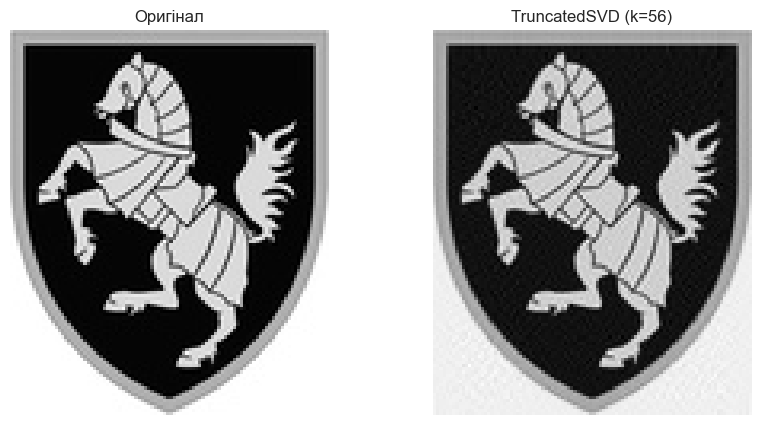

Помилка реконструкції (MSE) для 95.00% енергії: 1117.3680
Помилка реконструкції (MSE) для 99.00% енергії: 232.5064
Помилка реконструкції (MSE) для 99.90% енергії: 22.3677


In [51]:
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

# TruncatedSVD для k=56
svd = TruncatedSVD(n_components=56)
truncated_image = svd.fit_transform(original_gray)
reconstructed_image = svd.inverse_transform(truncated_image)

# Візуалізація
plt.figure(figsize=(10, 5))

# Оригінал
plt.subplot(1, 2, 1)
plt.imshow(original_gray, cmap="gray")
plt.title("Оригінал")
plt.axis("off")

# Реконструкція
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image, cmap="gray")
plt.title("TruncatedSVD (k=56)")
plt.axis("off")

plt.show()

# Обчислення помилки реконструкції для кожного порогу
for threshold, img in reconstructed_images.items():
    reconstruction_error = np.mean((img - original_gray) ** 2)
    print(f"Помилка реконструкції (MSE) для {threshold * 100:.2f}% енергії: {reconstruction_error:.4f}")

In [44]:
print("Розмір матриці зображення після обрізання по k=56")
np.shape(truncated_image)

Розмір матриці зображення після обрізання по k=56


(121, 56)

Для 95% енергії достатньо 18 компонентів.
Для 99% енергії достатньо 50 компонентів.
Для 100% енергії достатньо 117 компонентів.


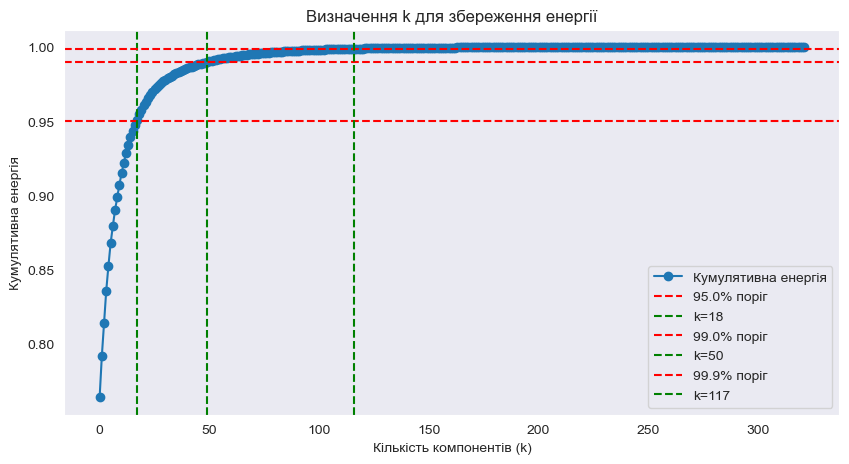

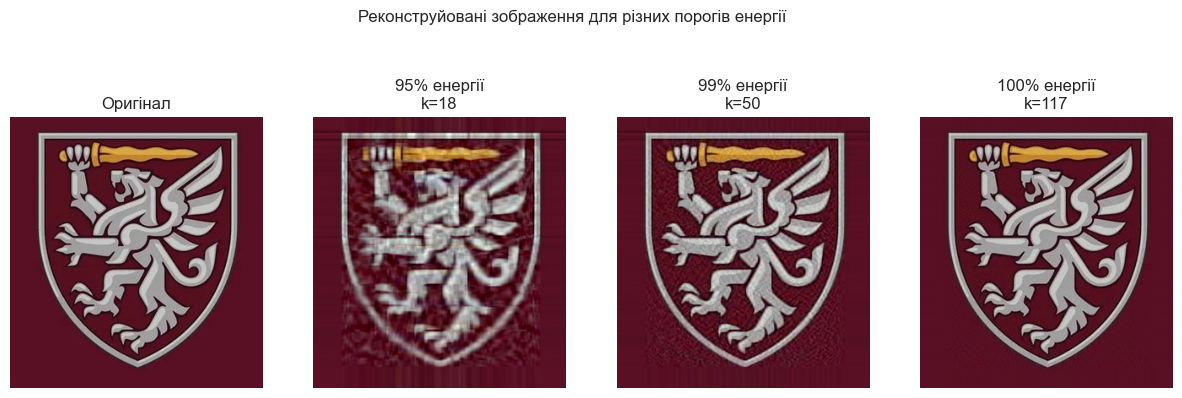

Помилка реконструкції (MSE) для 95.00% енергії: 62.1155
Помилка реконструкції (MSE) для 99.00% енергії: 40.4523
Помилка реконструкції (MSE) для 99.90% енергії: 9.7752


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from sklearn.decomposition import TruncatedSVD

# Функція для обчислення кумулятивної енергії та вибору k
def find_k_for_energy(Sigma, thresholds):
    total_energy = np.sum(Sigma ** 2)
    cumulative_energy = np.cumsum(Sigma ** 2) / total_energy
    k_values = {threshold: np.argmax(cumulative_energy >= threshold) + 1 for threshold in thresholds}
    return k_values, cumulative_energy

# Функція для виконання SVD та реконструкції кольорового зображення
def process_color_svd_image(image_path, energy_thresholds):
    # Завантаження зображення
    img = imread(image_path)

    # Зміна розміру матриці (3D -> 2D)
    height, width, channels = img.shape
    flat_image = img.reshape(-1, width * channels)

    # SVD
    U, Sigma, Vt = np.linalg.svd(flat_image, full_matrices=False)

    # Знайти значення k для заданих порогів енергії
    k_values, cumulative_energy = find_k_for_energy(Sigma, energy_thresholds)

    # Реконструкція зображень для різних k
    reconstructed_images = {}
    for threshold, k in k_values.items():
        Sigma_k = np.diag(Sigma[:k])
        reconstructed_img = (U[:, :k] @ Sigma_k @ Vt[:k, :]).reshape(height, width, channels)
        # Обрізаємо значення до [0, 255]
        reconstructed_images[threshold] = np.clip(reconstructed_img, 0, 255).astype('uint8')

    return img, k_values, cumulative_energy, reconstructed_images

# Параметри
energy_thresholds = [0.95, 0.99, 0.999]  # Пороги енергії
image_path = "data/80-min.jpeg"  # Шлях до кольорового зображення

# Обробка кольорового зображення
original_color, k_values, cumulative_energy, reconstructed_images = process_color_svd_image(image_path, energy_thresholds)

# Виведення k для порогів
for threshold, k in k_values.items():
    print(f"Для {threshold * 100:.0f}% енергії достатньо {k} компонентів.")

# Візуалізація кумулятивної енергії
plt.figure(figsize=(10, 5))
plt.plot(cumulative_energy, marker="o", label="Кумулятивна енергія")
for threshold, k in k_values.items():
    plt.axhline(threshold, color="r", linestyle="--", label=f"{threshold * 100}% поріг")
    plt.axvline(k - 1, color="g", linestyle="--", label=f"k={k}")
plt.xlabel("Кількість компонентів (k)")
plt.ylabel("Кумулятивна енергія")
plt.title("Визначення k для збереження енергії")
plt.legend()
plt.grid()
plt.show()

# Візуалізація реконструйованих зображень
plt.figure(figsize=(15, 5))
plt.subplot(1, len(energy_thresholds) + 1, 1)
plt.imshow(original_color)
plt.title("Оригінал")
plt.axis("off")

for i, (threshold, img) in enumerate(reconstructed_images.items()):
    plt.subplot(1, len(energy_thresholds) + 1, i + 2)
    plt.imshow(img)
    plt.title(f"{threshold * 100:.2f}% енергії\nk={k_values[threshold]}")
    plt.axis("off")

plt.suptitle("Реконструйовані зображення для різних порогів енергії")
plt.show()

# Обчислення помилки реконструкції для кожного порогу
flat_original = original_color.reshape(-1, original_color.shape[1] * original_color.shape[2])
for threshold, img in reconstructed_images.items():
    flat_reconstructed = img.reshape(-1, img.shape[1] * img.shape[2])
    reconstruction_error = np.mean((flat_reconstructed - flat_original) ** 2)
    print(f"Помилка реконструкції (MSE) для {threshold * 100:.2f}% енергії: {reconstruction_error:.4f}")